In [1]:
# Import needed packages 
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np
import random
from typing import Callable, Iterable, List, Dict, Optional, Tuple
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from __future__ import annotations
import os
import pandas as pd
import matplotlib.pyplot as plt

# Strategy update rules #

In [2]:
def choose_strategy_logit(agent, neighbors, a_I, b, tau):
    """Choose strategy using logit / softmax choice.

    Parameters
    - agent: the agent choosing a strategy
    - neighbors: list of neighbour agents
    - a_I: effective coordination payoff given current infrastructure
    - b: defection payoff
    - tau: temperature parameter for softmax
    """
    # compute expected payoffs for C and D
    pi_C = 0.0
    pi_D = 0.0
    for other in neighbors:
        s_j = other.strategy
        if s_j == "C":
            pi_C += a_I
            pi_D += b
        else:
            pi_C += 0.0
            pi_D += b

    # softmax choice
    denom = np.exp(pi_C / tau) + np.exp(pi_D / tau)
    P_C = np.exp(pi_C / tau) / denom if denom > 0 else 0.5
    return "C" if random.random() < P_C else "D"

# The Agent Class #

In [3]:
class EVAgent(Agent):
    """Single agent at a graph node.

    Attributes
    - strategy: "C" (adopt EV) or "D" (defect / ICE)
    - payoff: accumulated payoff from interactions with neighbours
    - next_strategy: strategy chosen for the next time step
    """

    def __init__(self, unique_id, model, init_strategy="D"):
        super().__init__(unique_id, model)
        self.strategy = init_strategy
        self.payoff = 0.0
        self.next_strategy = init_strategy

    def step(self):
        """Compute payoff from interactions with neighbours.

        Stag Hunt payoff rules:
        - C vs C: `a_I` (coordination enhanced by infrastructure)
        - C vs D: 0
        - D vs C: `b`
        - D vs D: `b`
        """
        I = self.model.infrastructure
        a0 = self.model.a0
        beta_I = self.model.beta_I
        b = self.model.b
        a_I = a0 + beta_I * I

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))
        if not neighbor_agents:
            self.payoff = 0.0
            return

        payoff = 0.0
        for other in neighbor_agents:
            s_i = self.strategy
            s_j = other.strategy
            if s_i == "C" and s_j == "C":
                payoff += a_I
            elif s_i == "C" and s_j == "D":
                payoff += 0.0
            elif s_i == "D" and s_j == "C":
                payoff += b
            else:
                payoff += b
        self.payoff = payoff

    ####################################
    # Advance method
    #
    # The advance method updates the agent's strategy based on the selected rule.
    #
    # Parameters
    # - strategy_choice_func: the strategy selection function to use ("logit")
    ####################################
    def advance(self, strategy_choice_func="logit"):
        """Update next_strategy using the selected rule.

        If called without an explicit rule, read `self.model.strategy_choice_func`.
        Commit `self.strategy = self.next_strategy` for synchronous updates.
        """
        # Default to logit, and treat any value ("imitate" or "logit") as logit.
        func = strategy_choice_func if strategy_choice_func is not None else getattr(
            self.model,
            "strategy_choice_func",
            "logit"
        )

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))

        if func in ("imitate", "logit"):
            # Always use logit as the actual update rule
            a_I = self.model.a0 + self.model.beta_I * self.model.infrastructure
            self.next_strategy = choose_strategy_logit(
                self,
                neighbor_agents,
                a_I,
                self.model.b,
                getattr(self.model, "tau", 1.0),
            )
        else:
            raise ValueError(f"Unknown strategy choice function: {func}")

        # Commit the update for SimultaneousActivation
        self.strategy = self.next_strategy

# EV Stag Hunt Model Implementation # 
with Different Network Types 

In [4]:
class EVStagHuntModel(Model):
    """Mesa model for EV Stag Hunt on a network."""

    def __init__(
        self,
        initial_ev=10,
        a0=2.0,
        beta_I=3.0,
        b=1.0,
        g_I=0.1,
        I0=0.05,
        seed=None,
        network_type="random",   # if nothing is selected, this default -> random network
        n_nodes=100,
        p=0.05,
        m=2,
        collect=True,
        strategy_choice_func: str = "imitate",
        tau: float = 1.0,
    ):
        super().__init__(seed=seed)

        # Build graph
        # Note: if network_type is not "BA" or "SW", an Erdős–Rényi random network is used.
        if network_type == "BA":
            # Barabási–Albert scale-free network
            G = nx.barabasi_albert_graph(n_nodes, m, seed=seed)
        elif network_type == "SW":
            # Watts–Strogatz small-world network
            # m is used as k (number of nearest neighbours), p is rewiring probability
            G = nx.watts_strogatz_graph(n_nodes, k=m, p=p, seed=seed)
        else:
            # Default: Erdős–Rényi random network
            G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)

        self.G = G
        self.grid = NetworkGrid(G)
        self.schedule = SimultaneousActivation(self)

        # parameters
        self.a0 = a0
        self.beta_I = beta_I
        self.b = b
        self.g_I = g_I
        self.infrastructure = I0
        self.step_count = 0
        self.strategy_choice_func = strategy_choice_func
        self.tau = tau

        # initialize node attribute for agent reference
        for n in self.G.nodes:
            self.G.nodes[n]["agent"] = []

        # choose initial EV nodes
        total_nodes = self.G.number_of_nodes()
        k_ev = max(0, min(initial_ev, total_nodes))
        ev_nodes = set(self.random.sample(list(self.G.nodes), k_ev))

        # create one agent per node
        uid = 0
        for node in self.G.nodes:
            init_strategy = "C" if node in ev_nodes else "D"
            agent = EVAgent(uid, self, init_strategy)
            uid += 1
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        self.datacollector = None
        if collect:
            self.datacollector = DataCollector(
                model_reporters={
                    "X": self.get_adoption_fraction,
                    "I": lambda m: m.infrastructure,
                },
                agent_reporters={"strategy": "strategy", "payoff": "payoff"},
            )

    def get_adoption_fraction(self):
        agents = self.schedule.agents
        if not agents:
            return 0.0
        return sum(1 for a in agents if a.strategy == "C") / len(agents)

    #######################
    # Model step function
    #
    # The step function advances the model by one time step.
    # It first advances all agents, then computes the adoption fraction and infrastructure level.
    # The infrastructure level is updated based on the adoption fraction and the infrastructure growth rate.
    # The updated infrastructure level is clipped to the interval [0, 1].
    # Finally, if data collection is enabled, the model and agent data are collected.
    #######################
    def step(self): 
        self.schedule.step()  # advance all agents
        X = self.get_adoption_fraction()  # compute adoption fraction after all agents have advanced
        I = self.infrastructure  # infrastructure level before this step
        dI = self.g_I * (X - I)  # infrastructure growth rate, impacted by adoption fraction
        self.infrastructure = float(min(1.0, max(0.0, I + dI)))  # clip infrastructure level to [0, 1]
        if self.datacollector is not None:
            self.datacollector.collect(self)  # collect data at the end of each step
        self.step_count += 1  # increment step count after data collection

# Initial Adopter Selection: Random #

In [5]:
#########################
# Set initial adopters 
#
# Parameters
# - model: the EVStagHuntModel instance
# - X0_frac: fraction of agents to initially choose EV adoption
# - seed: random seed for reproducibility
###########################
def set_initial_adopters(model, X0_frac, seed=None):
    """Set a fraction of agents to EV adopters using random selection."""
    rng = np.random.default_rng(seed)
    agents = model.schedule.agents
    n = len(agents)
    
    # number of adopters
    k = int(round(X0_frac * n))
    
    # reset all to D
    for a in agents:
        a.strategy = "D"
    
    if k <= 0:
        return
    
    # choose k random agents
    idx = rng.choice(n, size=k, replace=False)
    for i in idx:
        agents[i].strategy = "C"


# Run Network #
Runs network and returns final adoption

In [6]:
# -----------------------------
# Ratio sweep helpers (computation-only)
# -----------------------------
#########################
#
# Run a single network trial
# 
# Parameters
# - X0_frac: fraction of agents to initially choose EV adoption
# - ratio: payoff ratio between EV and DC agents (a0 = ratio*b - beta_I*I0)
# - I0: initial infrastructure level
# - beta_I: cost of EV adoption relative to DC (beta_I*I0)
# - b: payoff of EV (b)
# - g_I: infrastructure growth rate (g_I)
# - T: number of time steps to run
# - network_type: type of network to generate ("random", "BA", or "SW")
# - n_nodes: number of nodes in the network
# - p: probability of edge creation in random network / rewiring prob in SW
# - m: number of edges to attach from a new node to existing nodes in BA network /
#      k (number of nearest neighbours) in SW network
# - seed: random seed for reproducibility
# - tol: tolerance for convergence check (default: 1e-3)
# - patience: number of steps to wait for convergence (default: 30)
def run_network_trial(
    X0_frac: float,
    ratio: float,
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random", #choose network type here
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    seed: int | None = None,
    tol: float = 1e-3,
    patience: int = 30,
    collect: bool = False,
    strategy_choice_func: str = "logit",  
    tau: float = 1.0,
) -> float:
    """Run a single realisation and return final adoption fraction.

    Preserves the intended initial payoff ratio via a0 = ratio*b - beta_I*I0.
    Includes basic stability-based early stopping.
    """
    initial_ev = int(round(X0_frac * n_nodes))
    a0 = ratio * b - beta_I * I0

    model = EVStagHuntModel(
        initial_ev=initial_ev,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=collect,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    stable_steps = 0
    prev_X = None
    prev_I = None
    for _ in range(T):
        model.step()
        X = model.get_adoption_fraction()
        I = model.infrastructure
        if prev_X is not None and prev_I is not None:
            if abs(X - prev_X) < tol and abs(I - prev_I) < tol:
                stable_steps += 1
            else:
                stable_steps = 0
        prev_X, prev_I = X, I
        if X in (0.0, 1.0) and stable_steps >= 10:
            break
        if stable_steps >= patience:
            break

    return model.get_adoption_fraction()


# Final adoption vs payoff ratio #
This function runs multiple simulations for each payoff ratio, computes the final EV adoption in each run, and returns the mean adoption level for every ratio. This allows us to estimate how EV uptake depends on incentive strength and to detect tipping points in adoption dynamics.

In [7]:
#########################
#
# Compute final mean adoption fraction vs ratio
# 
##########################
def final_mean_adoption_vs_ratio(
    X0_frac: float,
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random",  # "random", "BA", or "SW"
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",  # default changed from "imitate" to "logit"
    tau: float = 1.0,
) -> np.ndarray:
    """Compute mean final adoption across a sweep of ratio values.

    For each ratio, average over `batch_size` trials with jittered `I0` and seeds.
    Returns a numpy array of means aligned with `ratio_values` order.
    """
    ratios = list(ratio_values)
    means: List[float] = []
    for ratio in ratios:
        finals: List[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        means.append(float(np.mean(finals)))
    return np.asarray(means, dtype=float)


# Generating Heatmap Rows #
Adoption vs Initial Conditions for a Fixed Ratio

In [8]:
#########################
#
# Compute final mean adoption fraction vs ratio
# 
##########################
def final_mean_adoption_vs_ratio(
    X0_frac: float,
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random",   # supports "random", "BA", "SW"
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",   # <-- changed from "imitate"
    tau: float = 1.0,
) -> np.ndarray:
    """
    Compute mean final EV adoption across a sweep of payoff ratios.

    For each ratio in ratio_values:
        - Run `batch_size` independent simulations
        - Each simulation randomly perturbs initial infrastructure I0 (noise)
        - Each uses a random seed for agent decisions and network processes
        - Record the final adoption fraction
    Return a numpy array of mean adoption values (same ordering as ratio_values).
    """
    ratios = list(ratio_values)
    means: List[float] = []

    for ratio in ratios:
        finals: List[float] = []

        for _ in range(batch_size):
            # Add small noise to initial infrastructure for robustness
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))

            # Fresh random seed for each run
            seed_j = np.random.randint(0, 2**31 - 1)

            # Run a single simulation
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)

        # Average final adoption across runs
        means.append(float(np.mean(finals)))

    return np.asarray(means, dtype=float)


# Whole Heatmap #
Adoption vs Initial Conditions for a Fixed Ratio

In [9]:
#########################
#
# Compute heatmap matrix for phase sweep
# 
##########################
def phase_sweep_X0_vs_ratio(
    X0_values: Iterable[float],
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 250,
    network_type: str = "BA",   # "random", "BA", or "SW"
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    max_workers: int | None = None,
    backend: str = "process",
) -> np.ndarray:
    """Compute a heatmap matrix of mean final adoption X* over (X0, ratio).

    Returns an array of shape (len(ratio_values), len(X0_values)) aligned with
    the provided orders. Rows correspond to ratios; columns to X0 values.
    """
    X0_values = list(X0_values)
    ratio_values = list(ratio_values)
    X_final = np.zeros((len(ratio_values), len(X0_values)), dtype=float)

    # Prepare tasks per ratio
    tasks: List[Dict] = []
    for ratio in ratio_values:
        tasks.append({
            "ratio": ratio,
            "X0_values": X0_values,
            "I0": I0,
            "beta_I": beta_I,
            "b": b,
            "g_I": g_I,
            "T": T,
            "network_type": network_type,
            "n_nodes": n_nodes,
            "p": p,
            "m": m,
            "batch_size": batch_size,
            "init_noise_I": init_noise_I,
            "strategy_choice_func": strategy_choice_func,
            "tau": tau,
        })

    if max_workers is None:
        try:
            max_workers = os.cpu_count() or 1
        except Exception:
            max_workers = 1

    Executor = ProcessPoolExecutor if backend == "process" and max_workers > 1 else ThreadPoolExecutor

    if max_workers > 1:
        with Executor(max_workers=max_workers) as ex:
            futures = [ex.submit(_row_for_ratio_task, args) for args in tasks]
            for i, fut in enumerate(futures):
                row = fut.result()
                X_final[i, :] = row
    else:
        for i, args in enumerate(tasks):
            row = _row_for_ratio_task(args)
            X_final[i, :] = row

    return X_final


## Plotting Functions ##

In [10]:
import os
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Helper: Automatic File Path for Saving Plots

In [11]:
def _default_plot_path(filename: str) -> str:
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    return os.path.join(plots_dir, filename)

Fan chart plot for baseline vs policy 

In [12]:
def plot_fanchart(traces_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot fan charts (quantile bands) for baseline vs subsidy using traces DF.

    traces_df columns: ['group', 'trial', 'time', 'X'] where group in {'baseline','subsidy'}.
    """
    if traces_df.empty:
        raise ValueError("traces_df is empty")

    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]

        # Compute quantiles by time across trials
        q = gdf.groupby("time")["X"].quantile([0.10, 0.25, 0.75, 0.90]).unstack(level=1)
        mean = gdf.groupby("time")["X"].mean()
        t = mean.index.to_numpy()

        ax = axes[0, j]
        ax.fill_between(t, q[0.10], q[0.90], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.15, label="10–90%")
        ax.fill_between(t, q[0.25], q[0.75], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.30, label="25–75%")

        # Overlay some traces for context (sample up to 100 trials)
        trial_ids = gdf["trial"].unique()
        rng = np.random.default_rng(123)
        sample = rng.choice(trial_ids, size=min(100, len(trial_ids)), replace=False)
        for tr in sample:
            tr_df = gdf[gdf["trial"] == tr]
            ax.plot(tr_df["time"], tr_df["X"], color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.1, linewidth=0.8)

        ax.plot(t, mean, color=("steelblue" if group == "baseline" else "darkorange"), linewidth=2, label="mean")
        ax.set_title(f"{group.capitalize()} adoption")
        ax.set_xlabel("Time")
        ax.set_ylabel("X(t)")
        ax.set_ylim(0, 1)
        ax.legend(loc="lower right")

        # Final X(T) histogram
        t_max = int(gdf["time"].max())
        final_vals = gdf[gdf["time"] == t_max].groupby("trial")["X"].mean().to_numpy()
        axes[1, j].hist(final_vals, bins=20, color=("steelblue" if group == "baseline" else "darkorange"), alpha=0.8)
        axes[1, j].set_title(f"{group.capitalize()} final X(T)")
        axes[1, j].set_xlabel("X(T)")
        axes[1, j].set_ylabel("Count")

    if out_path is None:
        out_path = _default_plot_path("ev_intervention_fanchart.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


Spaghetti Plot of Individual Adoption Trajectories

In [13]:
def plot_spaghetti(traces_df: pd.DataFrame, *, max_traces: int = 100, alpha: float = 0.15, out_path: Optional[str] = None) -> str:
    """Spaghetti plot from traces DF for baseline vs subsidy."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)
    rng = np.random.default_rng(123)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        trial_ids = gdf["trial"].unique()
        sample = rng.choice(trial_ids, size=min(max_traces, len(trial_ids)), replace=False)
        ax = axes[j]
        for tr in sample:
            tr_df = gdf[gdf["trial"] == tr]
            ax.plot(tr_df["time"], tr_df["X"], color=("steelblue" if group == "baseline" else "darkorange"), alpha=alpha, linewidth=0.8)
        ax.set_title(f"{group.capitalize()} traces")
        ax.set_xlabel("Time")
        ax.set_ylabel("X(t)")
        ax.set_ylim(0, 1)

    if out_path is None:
        out_path = _default_plot_path("ev_spaghetti.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


Density Plot of Adoption Dynamics (Baseline vs Subsidy) over time

In [14]:
def plot_density(traces_df: pd.DataFrame, *, x_bins: int = 50, time_bins: Optional[int] = None, out_path: Optional[str] = None) -> str:
    """Time-evolving density plot (2D histogram) from traces DF."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        T = int(gdf["time"].max()) + 1
        if time_bins is None:
            bins_time = T
        else:
            bins_time = time_bins
        hb = axes[j].hist2d(gdf["time"].to_numpy(), gdf["X"].to_numpy(), bins=[bins_time, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
        axes[j].set_title(f"{group.capitalize()} density: time vs X(t)")
        axes[j].set_xlabel("Time")
        axes[j].set_ylabel("X(t)")
        fig.colorbar(hb[3], ax=axes[j], label="count")

    if out_path is None:
        out_path = _default_plot_path("ev_density.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path

Density of Adoption Trajectories Over Time (Baseline vs Subsidy)


In [15]:
def plot_density(traces_df: pd.DataFrame, *, x_bins: int = 50, time_bins: Optional[int] = None, out_path: Optional[str] = None) -> str:
    """Time-evolving density plot (2D histogram) from traces DF."""
    groups = ["baseline", "subsidy"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), constrained_layout=True)

    for j, group in enumerate(groups):
        gdf = traces_df[traces_df["group"] == group]
        T = int(gdf["time"].max()) + 1
        if time_bins is None:
            bins_time = T
        else:
            bins_time = time_bins
        hb = axes[j].hist2d(gdf["time"].to_numpy(), gdf["X"].to_numpy(), bins=[bins_time, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
        axes[j].set_title(f"{group.capitalize()} density: time vs X(t)")
        axes[j].set_xlabel("Time")
        axes[j].set_ylabel("X(t)")
        fig.colorbar(hb[3], ax=axes[j], label="count")

    if out_path is None:
        out_path = _default_plot_path("ev_density.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path

Phase Plot: Long-Run Adoption as a Function of X0 and Payoff Ratio


In [16]:
def plot_phase_plot(phase_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    """Plot heatmap from tidy DataFrame with columns ['X0','ratio','X_final']."""
    # Pivot to matrix for imshow
    pivot = phase_df.pivot(index="ratio", columns="X0", values="X_final").sort_index().sort_index(axis=1)
    ratios = pivot.index.to_numpy()
    X0s = pivot.columns.to_numpy()

    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        pivot.to_numpy(),
        origin="lower",
        extent=[X0s[0], X0s[-1], ratios[0], ratios[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("a_I / b (initial payoff ratio)")
    plt.title("Network phase plot: X* over X0 and a_I/b")

    # Overlay threshold X = 1/ratio
    X_thresh = 1.0 / ratios
    X_thresh_clipped = np.clip(X_thresh, 0.0, 1.0)
    plt.plot(X_thresh_clipped, ratios, color="white", linestyle="--", linewidth=1.5, label="X = b / a_I (initial)")
    plt.legend(loc="upper right")

    if out_path is None:
        out_path = _default_plot_path("ev_phase_plot.png")
    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()
    return out_path

# Subsidy Policy #

In [17]:
"""
Experiment utilities for the EV Stag Hunt model.

Contains policy factory functions, trial runners, multiprocessing helpers,
and standalone plotting routines. Depends on `ev_core` for the model.
"""

from __future__ import annotations

import os
from typing import Callable, Dict, Optional, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# -----------------------------
# Policy factories (subsidy)
# -----------------------------

def policy_subsidy_factory(start: int, end: int, delta_a0: float = 0.3, delta_beta_I: float = 0.0) -> Callable:
    """Create a policy that temporarily boosts coordination payoffs.

    Raises `a0` and/or `beta_I` during `[start, end)` and reverts after.
    Returns a closure `policy(model, step)`.
    """

    def policy(model, step):
        if not hasattr(policy, "base_a0"):
            policy.base_a0 = model.a0
        if not hasattr(policy, "base_beta_I"):
            policy.base_beta_I = model.beta_I

        if start <= step < end:
            model.a0 = policy.base_a0 + delta_a0
            model.beta_I = policy.base_beta_I + delta_beta_I
        else:
            model.a0 = policy.base_a0
            model.beta_I = policy.base_beta_I

    return policy


# -----------------------------
# Trial runner
# -----------------------------

def run_timeseries_trial(
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    seed: Optional[int] = None,
    policy: Optional[Callable] = None,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """Run one simulation; return X(t), I(t), and model vars dataframe."""

    scenario = {
        "a0": 2.0,
        "ratio": None,
        "beta_I": 3.0,
        "b": 1.0,
        "g_I": 0.1,
        "I0": 0.05,
        "network_type": "random",
        "n_nodes": 100,
        "p": 0.05,
        "m": 2,
        "collect": True,
        "X0_frac": 0.0,
        "init_method": "random",
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    # Compute a0 from ratio if provided
    a0_for_model = scenario["a0"]
    if scenario.get("ratio") is not None:
        a0_for_model = (
            float(scenario["ratio"]) * float(scenario["b"])
            - float(scenario["beta_I"]) * float(scenario["I0"])
        )
    model = EVStagHuntModel(
        initial_ev=0,                     
        a0=a0_for_model,
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        I0=scenario["I0"],
        seed=seed,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        collect=True,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    # Set initial adopters AFTER model creation
    if scenario.get("X0_frac", 0.0) > 0.0:
        set_initial_adopters(
            model,
            scenario["X0_frac"],
            method=scenario.get("init_method", "random"),
            seed=seed,
        )

    for t in range(T):
        if policy is not None:
            policy(model, t)
        model.step()

    df = model.datacollector.get_model_vars_dataframe().copy()
    return df["X"].to_numpy(), df["I"].to_numpy(), df


def _timeseries_trial_worker(args_dict: Dict) -> Tuple[np.ndarray, np.ndarray]:
    """Worker for parallel trials that reconstructs closures for policies."""
    T = args_dict["T"]
    scenario_kwargs = args_dict.get("scenario_kwargs", {})
    seed = args_dict.get("seed", None)
    policy_spec = args_dict.get("policy", None)
    strategy_choice_func = args_dict.get("strategy_choice_func", "logit")
    tau = args_dict.get("tau", 1.0)

    policy = None
    if isinstance(policy_spec, dict):
        ptype = policy_spec.get("type")
        if ptype == "subsidy":
            policy = policy_subsidy_factory(**policy_spec["params"])
        # no infrastructure policy anymore

    X, I, _df = run_timeseries_trial(
        T=T,
        scenario_kwargs=scenario_kwargs,
        seed=seed,
        policy=policy,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    return X, I


# -----------------------------
# Experiment: Intervention trials + plotting
# -----------------------------

def collect_intervention_trials(
    n_trials: int = 10,
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    subsidy_params: Optional[Dict] = None,
    max_workers: int = 1,
    seed_base: int = 42,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray], pd.DataFrame, pd.DataFrame]:
    """Run baseline and subsidy trials; return raw trajectories and summary dataframes."""

    scenario = scenario_kwargs or {}
    subsidy = subsidy_params or {"start": 30, "end": 80, "delta_a0": 0.3, "delta_beta_I": 0.0}

    baseline_args = []
    subsidy_args = []
    for i in range(n_trials):
        seed = seed_base + i
        baseline_args.append(
            {
                "T": T,
                "scenario_kwargs": scenario,
                "seed": seed,
                "policy": None,
                "strategy_choice_func": strategy_choice_func,
                "tau": tau,
            }
        )
        subsidy_args.append(
            {
                "T": T,
                "scenario_kwargs": scenario,
                "seed": seed,
                "policy": {"type": "subsidy", "params": subsidy},
                "strategy_choice_func": strategy_choice_func,
                "tau": tau,
            }
        )

    baseline_X, baseline_I = [], []
    subsidy_X, subsidy_I = [], []

    # Run sequentially or concurrently
    Executor = ThreadPoolExecutor if max_workers == 1 else ProcessPoolExecutor
    with Executor(max_workers=max_workers) as ex:
        baseline_futs = [ex.submit(_timeseries_trial_worker, args) for args in baseline_args]
        subsidy_futs = [ex.submit(_timeseries_trial_worker, args) for args in subsidy_args]
        for fut in as_completed(baseline_futs):
            X, I = fut.result()
            baseline_X.append(X)
            baseline_I.append(I)
        for fut in as_completed(subsidy_futs):
            X, I = fut.result()
            subsidy_X.append(X)
            subsidy_I.append(I)

    # Align order by seed (as_completed may scramble)
    baseline_X = sorted(baseline_X, key=lambda arr: tuple(arr))
    subsidy_X = sorted(subsidy_X, key=lambda arr: tuple(arr))

    # Summary stats
    def summarize(X_list: List[np.ndarray]) -> pd.DataFrame:
        mat = np.vstack(X_list)
        df = pd.DataFrame({
            "X_mean": mat.mean(axis=0),
            "X_med": np.median(mat, axis=0),
            "X_q10": np.quantile(mat, 0.10, axis=0),
            "X_q25": np.quantile(mat, 0.25, axis=0),
            "X_q75": np.quantile(mat, 0.75, axis=0),
            "X_q90": np.quantile(mat, 0.90, axis=0),
        })
        return df

    baseline_df = summarize(baseline_X)
    subsidy_df = summarize(subsidy_X)

    return baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df, subsidy_df


def traces_to_long_df(baseline_X: List[np.ndarray], subsidy_X: List[np.ndarray]) -> pd.DataFrame:
    """Convert trajectory lists to a tidy DataFrame: [group, trial, time, X]."""
    rows = []
    for trial, X in enumerate(baseline_X):
        for t, x in enumerate(X):
            rows.append(("baseline", trial, t, float(x)))
    for trial, X in enumerate(subsidy_X):
        for t, x in enumerate(X):
            rows.append(("subsidy", trial, t, float(x)))
    return pd.DataFrame(rows, columns=["group", "trial", "time", "X"])


def ratio_sweep_df(
    X0_frac: float = 0.40,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    T: int = 250,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> pd.DataFrame:
    """Compute X* vs ratio and return as a DataFrame."""
    scenario = {
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "I0": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    X_means = final_mean_adoption_vs_ratio(
        X0_frac,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    return pd.DataFrame({"ratio": ratio_values, "X_mean": X_means})


def phase_sweep_df(
    max_workers: int | None = None,
    backend: str = "process",
    X0_values: Optional[np.ndarray] = None,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    T: int = 250,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> pd.DataFrame:
    """Compute tidy DataFrame of X* over (X0, ratio)."""
    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 21)
    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    scenario = {
        "I0": 0.05,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    X_final = phase_sweep_X0_vs_ratio(
        X0_values,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        max_workers=max_workers or 1,
        backend=backend,
    )

    rows = []
    for i, X0 in enumerate(X0_values):
        for j, ratio in enumerate(ratio_values):
            rows.append((float(X0), float(ratio), float(X_final[j, i])))
    return pd.DataFrame(rows, columns=["X0", "ratio", "X_final"])


def run_ratio_sweep_plot(
    X0_frac: float = 0.40,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    T: int = 250,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    out_path: Optional[str] = None,
) -> str:
    """Sweep ratio values and plot final adoption X* vs a_I/b for a fixed X0.

    Calls the core computation helper and saves a simple line plot.
    Returns the path to the saved image.
    """
    scenario = {
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "I0": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    X_means = final_mean_adoption_vs_ratio(
        X0_frac,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(ratio_values, X_means, color="C0", lw=2)
    ax.set_xlabel("a_I / b (ratio)")
    ax.set_ylabel("Final adoption X*")
    ax.set_title(f"X* vs ratio for X0={X0_frac:.2f}")
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.25)

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_ratio_sweep.png")
    fig.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close(fig)
    return out_path


def run_phase_plot_X0_vs_ratio_network(
    max_workers: int | None = None,
    backend: str = "process",
    X0_values: Optional[np.ndarray] = None,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    T: int = 250,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    out_path: Optional[str] = None,
) -> str:
    """Produce a heatmap of X* over (X0, a_I/b) using core sweep helper.

    Saves a figure similar to the original model script and returns the path.
    """
    # Defaults aligned with the original phase plot
    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 21)
    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    scenario = {
        "I0": 0.05,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 120,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    X_final = phase_sweep_X0_vs_ratio(
        X0_values,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        max_workers=max_workers or 1,
        backend=backend,
    )

    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        X_final,
        origin="lower",
        extent=[X0_values[0], X0_values[-1], ratio_values[0], ratio_values[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("a_I / b (initial payoff ratio)")
    plt.title("Network phase plot: X* over X0 and a_I/b")

    # Overlay initial threshold X = b/a_I => X = 1/ratio
    X_thresh = 1.0 / ratio_values
    X_thresh_clipped = np.clip(X_thresh, 0.0, 1.0)
    plt.plot(
        X_thresh_clipped,
        ratio_values,
        color="white",
        linestyle="--",
        linewidth=1.5,
        label="X = b / a_I (initial)",
    )

    plt.legend(loc="upper right")

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_phase_plot.png")
    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()
    return out_path


def run_intervention_example(
    n_trials: int = 10,
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    subsidy_params: Optional[Dict] = None,
    max_workers: int = 1,
    seed_base: int = 42,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> Tuple[pd.DataFrame, pd.DataFrame, str]:
    """Convenience: collect trials, plot, and return summary + image path."""

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df, subsidy_df = collect_intervention_trials(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario_kwargs,
        subsidy_params=subsidy_params,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    # Use DataFrame-based plotting to ensure outputs go to plots/
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    img_path = plot_fanchart(traces_df)
    return baseline_df, subsidy_df, img_path


# -----------------------------
# CLI Entrypoint (optional)
# -----------------------------

def main():
    # Defaults aligned with original ev_stag_mesa_model.run_intervention_example
    n_trials = 30  # use fewer than 500 for speed while keeping shape
    T = 200
    strategy_choice_func = "logit"
    tau = 1.0
    max_workers = 1
    seed_base = 100

    scenario = dict(
        # Preserve initial ratio by computing a0 from ratio, matching the original
        ratio=2.3,
        beta_I=2.0,
        b=1.0,
        g_I=0.10,
        I0=0.05,
        network_type="BA",
        n_nodes=300,
        m=2,
        collect=True,
        X0_frac=0.40,
        init_method="random",
        # ER-specific `p` ignored for BA but kept for completeness
        p=0.05,
    )
    subsidy = dict(start=10, end=60, delta_a0=0.4, delta_beta_I=0.0)

    baseline_df, subsidy_df, img_path = run_intervention_example(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    print("Baseline DF shape:", baseline_df.shape)
    print("Subsidy DF shape:", subsidy_df.shape)
    print("Saved image:", img_path)
    print("Baseline final X_mean:", float(baseline_df["X_mean"].iloc[-1]))
    print("Subsidy  final X_mean:", float(subsidy_df["X_mean"].iloc[-1]))

    # Also run the phase plot of X* over (X0, a_I/b) and save it
    phase_df = phase_sweep_df(
        max_workers=1,
        backend="thread",
        X0_values=np.linspace(0.0, 1.0, 21),
        ratio_values=np.linspace(0.8, 3.5, 31),
        batch_size=8,
        T=200,
        strategy_choice_func="logit",
        tau=1.0,
    )
    phase_path = plot_phase_plot(phase_df)
    print("Saved phase plot:", phase_path)

    # Spaghetti and time-evolving density plots
    n_trials_spaghetti = 100
    T_spaghetti = 200

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df2, subsidy_df2 = collect_intervention_trials(
        n_trials=n_trials_spaghetti,
        T=T_spaghetti,
        scenario_kwargs=scenario,
        subsidy_params=subsidy,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    spaghetti_path = plot_spaghetti(traces_df, max_traces=100, alpha=0.15)
    print("Saved spaghetti plot:", spaghetti_path)

    density_path = plot_density(traces_df, x_bins=50, time_bins=T_spaghetti)
    print("Saved time-evolving density plot:", density_path)

    # Ratio sweep computed to DF then plotted
    sweep_df = ratio_sweep_df(
        X0_frac=scenario.get("X0_frac", 0.40),
        ratio_values=np.linspace(0.8, 3.5, 31),
        scenario_kwargs=scenario,
        T=200,
        batch_size=8,
        strategy_choice_func="logit",
        tau=1.0,
    )
    sweep_path = plot_ratio_sweep(sweep_df)
    print("Saved ratio sweep plot:", sweep_path)





# Experiment runner #

Heatmap: Final doption vs X0,I0

In [27]:
def heatmap_Xstar_X0_I0(
    X0_values,
    I0_values,
    *,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.10,
    T=200,
    batch_size=5,
    network_type="BA",
    n_nodes=200,
    p=0.05,
    m=2,
    tau=1.0
):
    """
    Compute mean final adoption X* over a grid of (X0, I0).
    Returns: X0_vals, I0_vals, H where H[i, j] corresponds to I0[i], X0[j].
    """
    X0_values = list(X0_values)
    I0_values = list(I0_values)
    H = np.zeros((len(I0_values), len(X0_values)), dtype=float)

    for i, I0 in enumerate(I0_values):
        for j, X0 in enumerate(X0_values):
            finals = []
            for _ in range(batch_size):
                seed = np.random.randint(0, 2**31 - 1)
                x_star = run_network_trial(
                    X0_frac=float(X0),
                    ratio=float(ratio),
                    I0=float(I0),
                    beta_I=float(beta_I),
                    b=float(b),
                    g_I=float(g_I),
                    T=int(T),
                    network_type=str(network_type),
                    n_nodes=int(n_nodes),
                    p=float(p),
                    m=int(m),
                    seed=int(seed),
                    collect=False,
                    strategy_choice_func="logit",
                    tau=float(tau),
                )
                finals.append(x_star)
            H[i, j] = float(np.mean(finals))

    return np.asarray(X0_values, dtype=float), np.asarray(I0_values, dtype=float), H


def plot_heatmap_X0_I0(X0_vals, I0_vals, H, title="Final adoption X* vs (X0, I0)"):
    """Plot heatmap with X0 on x-axis, I0 on y-axis."""
    plt.figure(figsize=(7, 4.5))
    im = plt.imshow(
        H,
        origin="lower",
        extent=[X0_vals[0], X0_vals[-1], I0_vals[0], I0_vals[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adoption X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("I0 (initial infrastructure)")
    plt.title(title)
    plt.show()


# Change this for faster running
X0_vals = np.linspace(0.0, 1.0, 11)
I0_vals = np.linspace(0.0, 1.0, 11)

X0v, I0v, H = heatmap_Xstar_X0_I0(
    X0_vals,
    I0_vals,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.10,
    T=200,
    batch_size=5,
    network_type="BA",  # change to "random" or "SW" if you want
    n_nodes=200,
    p=0.05,
    m=2,
    tau=1.0
)

plot_heatmap_X0_I0(X0v, I0v, H, title="BA: Final adoption X* vs (X0, I0)")


print("Min X*:", float(H.min()), "Max X*:", float(H.max()))

KeyboardInterrupt: 

Phase plot trajectory: I(t) vs X(t)

In [26]:
def plot_phase_trajectory_from_trial(X, I, title="Phase trajectory (I vs X)"):
    t = np.arange(len(X))
    fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)

    axes[0].plot(t, X, label="X(t)")
    axes[0].plot(t, I, label="I(t)")
    axes[0].set_ylim(0, 1)
    axes[0].set_xlabel("Time")
    axes[0].legend()

    axes[1].plot(X, I)
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel("X(t)")
    axes[1].set_ylabel("I(t)")
    axes[1].set_title("Phase plane")

    fig.suptitle(title)
    plt.show()

scenario = dict(ratio=2.3, beta_I=2.0, b=1.0, g_I=0.10, I0=0.05,
                network_type="BA", n_nodes=300, m=2, p=0.05,
                X0_frac=0.10, init_method="random")
X, I, _ = run_timeseries_trial(T=250, scenario_kwargs=scenario, seed=1,
                               strategy_choice_func="logit", tau=1.0)
plot_phase_trajectory_from_trial(X, I, title="BA, low X0")

scenario["X0_frac"] = 0.50
X2, I2, _ = run_timeseries_trial(T=250, scenario_kwargs=scenario, seed=1,
                                 strategy_choice_func="logit", tau=1.0)
plot_phase_trajectory_from_trial(X2, I2, title="BA, high X0")


TypeError: set_initial_adopters() got an unexpected keyword argument 'method'

βI sensitivity curve

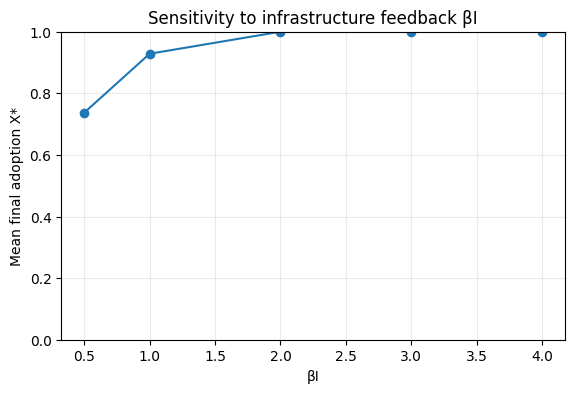

In [28]:
def beta_sensitivity_curve(
    beta_values, *, X0_frac=0.30, I0=0.05, ratio=2.3,
    b=1.0, g_I=0.10, T=250, batch_size=10,
    network_type="BA", n_nodes=225, p=0.05, m=2, tau=1.0
):
    rows = []
    for beta_I in beta_values:
        finals = []
        for _ in range(batch_size):
            seed = np.random.randint(0, 2**31 - 1)
            finals.append(run_network_trial(
                X0_frac=X0_frac, ratio=ratio, I0=I0,
                beta_I=beta_I, b=b, g_I=g_I, T=T,
                network_type=network_type, n_nodes=n_nodes, p=p, m=m,
                seed=seed, collect=False, strategy_choice_func="logit", tau=tau
            ))
        rows.append((beta_I, float(np.mean(finals))))
    return pd.DataFrame(rows, columns=["beta_I", "X_star_mean"])

df_beta = beta_sensitivity_curve(beta_values=[0.5, 1.0, 2.0, 3.0, 4.0])
plt.figure(figsize=(6.5, 4))
plt.plot(df_beta["beta_I"], df_beta["X_star_mean"], marker="o")
plt.ylim(0, 1)
plt.xlabel("βI")
plt.ylabel("Mean final adoption X*")
plt.title("Sensitivity to infrastructure feedback βI")
plt.grid(alpha=0.25)
plt.show()


BA vs ER vs SW

,X_star,hit_high,t_hit,cluster_frac
network,,,,
BA,0.998667,1.0,21.075,0.998667
SW,0.996500,1.0,6.425,0.786083
random,0.000167,0.0,-1.000,0.000167


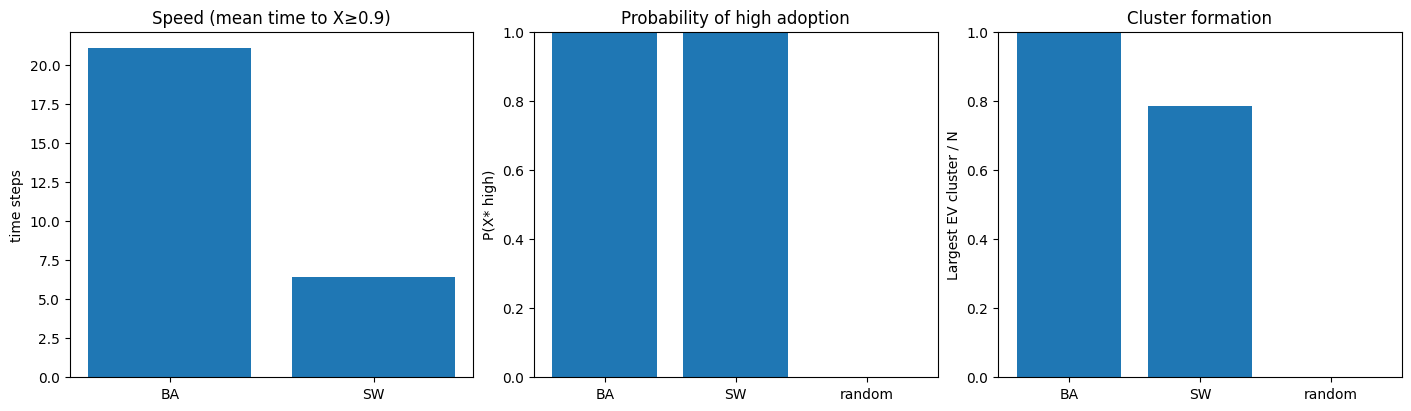

In [ ]:
def time_to_threshold(X_series, thresh=0.9):
    X_series = np.asarray(X_series)
    idx = np.where(X_series >= thresh)[0]
    return int(idx[0]) if len(idx) else None

def largest_ev_cluster_fraction(model) -> float:
    """Largest connected component size among EV adopters at the end."""
    ev_nodes = []
    for node in model.G.nodes:
        agents = model.grid.get_cell_list_contents([node])
        if agents and agents[0].strategy == "C":
            ev_nodes.append(node)
    if len(ev_nodes) == 0:
        return 0.0
    sub = model.G.subgraph(ev_nodes)
    comps = list(nx.connected_components(sub))
    if not comps:
        return 0.0
    return max(len(c) for c in comps) / model.G.number_of_nodes()

def run_single_topology_trial(
    *,
    network_type: str,
    X0_frac: float,
    ratio: float,
    I0: float,
    beta_I: float,
    b: float,
    g_I: float,
    T: int,
    n_nodes: int,
    p: float,
    m: int,
    seed: int,
    tau: float = 1.0,
    high_thresh: float = 0.9,
):
    initial_ev = int(round(X0_frac * n_nodes))
    a0 = ratio * b - beta_I * I0

    model = EVStagHuntModel(
        initial_ev=initial_ev,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=True,                 # we want time series
        strategy_choice_func="logit",
        tau=tau,
    )

    X_series = []
    for _ in range(T):
        model.step()
        X_series.append(model.get_adoption_fraction())

    X_star = float(X_series[-1])
    hit_high = 1.0 if X_star >= high_thresh else 0.0
    t_hit = time_to_threshold(X_series, thresh=high_thresh)
    t_hit_val = -1 if t_hit is None else t_hit
    cluster = largest_ev_cluster_fraction(model)

    return X_star, hit_high, t_hit_val, cluster

def topology_benchmark_df(
    network_types=("BA", "random", "SW"),
    *,
    X0_frac=0.30,
    ratio=2.3,
    I0=0.05,
    beta_I=2.0,
    b=1.0,
    g_I=0.10,
    T=250,
    n_trials=50,
    n_nodes=300,
    p=0.05,
    m=2,
    tau=1.0,
    high_thresh=0.9,
):
    rows = []
    for net in network_types:
        for k in range(n_trials):
            seed = 10000 + k
            X_star, hit_high, t_hit, cluster = run_single_topology_trial(
                network_type=net,
                X0_frac=X0_frac,
                ratio=ratio,
                I0=I0,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed,
                tau=tau,
                high_thresh=high_thresh,
            )
            rows.append((net, X_star, hit_high, t_hit, cluster))
    return pd.DataFrame(rows, columns=["network", "X_star", "hit_high", "t_hit", "cluster_frac"])

def plot_topology_metrics(df: pd.DataFrame, high_thresh=0.9):
    # Speed: mean time to reach high adoption, ignoring failures (t_hit=-1)
    speed = df[df["t_hit"] >= 0].groupby("network")["t_hit"].mean()
    # Probability: fraction reaching high equilibrium
    prob = df.groupby("network")["hit_high"].mean()
    # Clusters: mean largest-cluster fraction
    clus = df.groupby("network")["cluster_frac"].mean()

    fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

    axes[0].bar(speed.index, speed.values)
    axes[0].set_title(f"Speed (mean time to X≥{high_thresh})")
    axes[0].set_ylabel("time steps")

    axes[1].bar(prob.index, prob.values)
    axes[1].set_title("Probability of high adoption")
    axes[1].set_ylabel("P(X* high)")
    axes[1].set_ylim(0, 1)

    axes[2].bar(clus.index, clus.values)
    axes[2].set_title("Cluster formation")
    axes[2].set_ylabel("Largest EV cluster / N")
    axes[2].set_ylim(0, 1)

    plt.show()

# ---- RUN IT ----
df_top = topology_benchmark_df(
    network_types=("BA", "random", "SW"),
    X0_frac=0.30,
    ratio=2.3,
    I0=0.05,
    beta_I=2.0,
    T=250,
    n_trials=40,      # increase if you want smoother stats
    n_nodes=300,
    p=0.05,
    m=2,
    tau=1.0
)

display(df_top.groupby("network")[["X_star", "hit_high", "t_hit", "cluster_frac"]].mean())
plot_topology_metrics(df_top, high_thresh=0.9)

def tipping_sensitivity_by_network(
    network_types=("BA","random","SW"),
    X0_values=None,
    *,
    ratio=2.3,
    I0=0.05,
    beta_I=2.0,
    b=1.0,
    g_I=0.10,
    T=250,
    n_trials=25,
    n_nodes=300,
    p=0.05,
    m=2,
    tau=1.0,
    high_thresh=0.9,
):
    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 11)

    rows = []
    for net in network_types:
        for X0 in X0_values:
            hits = []
            for k in range(n_trials):
                seed = np.random.randint(0, 2**31 - 1)
                X_star, hit_high, t_hit, cluster = run_single_topology_trial(
                    network_type=net,
                    X0_frac=float(X0),
                    ratio=ratio,
                    I0=I0,
                    beta_I=beta_I,
                    b=b,
                    g_I=g_I,
                    T=T,
                    n_nodes=n_nodes,
                    p=p,
                    m=m,
                    seed=seed,
                    tau=tau,
                    high_thresh=high_thresh,
                )
                hits.append(hit_high)
            rows.append((net, float(X0), float(np.mean(hits))))
    return pd.DataFrame(rows, columns=["network","X0","P_high"])

df_tip = tipping_sensitivity_by_network(
    network_types=("BA","random","SW"),
    X0_values=np.linspace(0,1,11),
    n_trials=20,
    T=250,
    n_nodes=300,
)

plt.figure(figsize=(7,4.5))
for net, g in df_tip.groupby("network"):
    plt.plot(g["X0"], g["P_high"], marker="o", label=net)
plt.ylim(0,1)
plt.xlabel("X0 (initial adoption)")
plt.ylabel("P(high-adoption equilibrium)")
plt.title("Tipping sensitivity by topology")
plt.grid(alpha=0.25)
plt.legend()
plt.show()
